This is the Jupiter notebook accompanying the paper: "Applications of Machine Learning to Detecting Fast Neutrino Flavor Instabilities in Core-Collapse Supernova and Neutron Star Merger Models", arXiv:2303.05560.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy import integrate
from scipy import special
from scipy.optimize import fsolve
import math
import random

import warnings
warnings.filterwarnings('ignore')  # Comment this to turn on warnings

from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

random.seed(10)

In [3]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

# Producing the data using parametric angular distributions 


We here train/test our ML algorithms by
 using parametric neutrino angular distributions. The justifications for this choice are clearly explained in the paper (Sec. II. A).
We use two parametric neutrino angular distributions.
The first one is the maximum entropy distribution
defined as, 

\begin{equation}
f^{\rm{max-ent}}_\nu(\mu) = \frac{1}{ \exp[\eta - a\mu]},
\end{equation}

where 

\begin{equation}
 f_{\nu}(\mu) =  \int_0^\infty \int_0^{2\pi} \frac{E_\nu^2 \mathrm{d} E_\nu \mathrm{d} \phi_\nu}{(2\pi)^3} 
        f_{\nu}(\mathbf{p}).
\end{equation}

Another angular distribution considered here is  the Gaussian distribution defined as,

\begin{equation}
f^{\rm{Gauss}}_\nu(\mu) = A\exp[-\frac{(1-\mu)^2}{a}].
\end{equation}

Note that both of these distributions have parameters which determine the overall neutrino number density, namely
$\eta$ and $A$, and the other parameter  determining the shape of the distribution, i.e., $a$.


In this study, we are interested in the following integrated quantities:

\begin{equation}
\alpha = I^{\bar\nu_e}_0/I^{\nu_e}_0,\  F_{\nu_e} = I^{\nu_e}_1/I^{\nu_e}_0,\ \mathrm{and}\ F_{\bar\nu_e} = I^{\bar\nu_e}_1/I^{\bar\nu_e}_0,
\end{equation}

which are related to the neutrino angular distributions as,

 \begin{equation}
I_n = \int_{-1}^{1} \mathrm{d}\mu\ \mu^n\ \int_0^\infty \int_0^{2\pi} \frac{E_\nu^2 \mathrm{d} E_\nu \mathrm{d} \phi_\nu}{(2\pi)^3} \
        f_{\nu}(\mathbf{p}).
\end{equation}



<br><br>

In the following cell, we develop a parent class called "**AngDist**". This class contains some general methods which perform a range of calculations for the neutrino angular distributions of any type. We have also developed two child classes, namely "*MaxentDist*" and "*GaussianDist*", which represent the maximum entropy and Gaussian angular distributions. In order to *generalize* our distributions, one can easily define the angular distribution (child) class of one's  own. 


In [4]:
class AngDist:
    """ 
    This class is the parent class of the neutrino angular distributions.
    
    ...
    
    Attributes
    ----------
    dist_type : str
        the angular distribution type (currently 'Gaussian' and 'max_ent' are included)
    args, kwargs : float
        the parameters of the angular distributions
        
    Methods
    -------
    params_setter(I_0, flux_factor):
        finds and sets the parameters of the angular distributions, given the values of the neutrino number 
        density, I0, and the flux_factor, using the internal method _params_finder(I_0, flux_factor).
    _params_finder(I_0, flux_factor):
        internal method which helps the 'params_setter' method
    check_solver():
        makes sure that the 'fsolve' has worked well enough (in the 'params_setter' method).
    check_crossing(dist_1, dist_2):
        checks if there is a crossing between the AngDist instances, dist_1 and dist_2. Note that crossings
        are considered only if they are wider than 0.01.
    """
    
    def __init__(self, dist_type, *args, **kwargs):
        self.dist_type = dist_type
        self.args = args
        self.kwargs = kwargs
        
    def params_setter(self, I_0, flux_factor_val):
        self.args = self._params_finder(I_0, flux_factor_val)
                 
    def _params_finder(self, I_0, flux_factor_val):
        shape_factor = fsolve(lambda x: self.flux_factor(1., x) - flux_factor_val, .1) # The first argument of flux_factor is arbitrary
        normalization_factor = fsolve(lambda x: self.I0(x, shape_factor) - I_0, .1)
        return normalization_factor, shape_factor
         
    def check_solver(self):
        _I0_ini, _F_ini = self.I0(*self.args), self.flux_factor(*self.args)
        self.params_setter(_I0_ini, _F_ini)
        _I0_fin, _F_fin = self.I0(*self.args), self.flux_factor(*self.args)
        difference = np.linalg.norm(np.array([_I0_fin - _I0_ini, _F_fin - _F_ini]))
        r = False
        if difference<1.e-2: r = True
        return r
    
    @staticmethod
    def check_crossing(dist_1, dist_2):
        if isinstance(dist_1, AngDist) and isinstance(dist_2, AngDist):
            x = np.arange(-1.,1.01,.01)                      # Only crossings > 0.01 are considered.

            T = np.sign(dist_1.I0(*dist_1.args) - dist_2.I0(*dist_2.args)) * (dist_1.angular_distribution(x) - dist_2.angular_distribution(x) )
           
            r, x_c = False, None        # x_c is the crossing x
            if (T<0).any():
                r = True
                x_c = np.min(x[T[:]<0])      # We assume a single crossing
                if np.abs(x_c+1)<0.01: x_c = np.max(x[T[:]<0])  
            return r, x_c
        else: raise TypeError('distributions are not an instance of the AngDist class')
            
class MaxentDist(AngDist):
    """ 
    The maximum entropy neutrino angular distributions with the shape 'f_nu(mu) = 1./exp(eta-a*mu)'.
    
    ...
    
    Attributes
    ----------
    args : eta, a
        
    Methods
    -------
    angular_distribution(self, mu):
        the angular distribution as a function of mu = cos\theta
    I0(self, *args):
        the total neutrino number density, i.e., I0 = int_{-1}^{+1} f_nu(mu) d_mu 
    flux_factor(self, *args):
        the neutrino flux factor = I1/I0, where I1 = int_{-1}^{+1} mu*f_nu(mu) d_mu 
    """
    
    # Note that the second argument represents the shape (for generalization)
    def __init__(self, eta=1, a=1):
        super().__init__('max_ent', eta, a)
            
    def angular_distribution(self, mu):
        eta , a = self.args
        return np.exp(-eta+a*mu)
        
    # Note that since 'I0' and 'flux_factor' methods are to be used in 'AngDist.params_setter()' in order
    # to solve for self.args, args is also given as a parameter to this function.
    def I0(self, *args):
        eta , a = args
        return 2*np.exp(-eta)*np.sinh(a)/a
      
    # See the explanation above I0(self, *args). 
    def flux_factor(self, *args):
        eta , a = args
        return np.cosh(a)/np.sinh(a) - 1./a
    
    
    
    
    
class GaussianDist(AngDist):
    """ 
    The Gaussian neutrino angular distributions with the shape 'f_nu(mu) = A*exp( -(1-mu)**2/a )'.
    
    ...
    
    Attributes
    ----------
    args : A, a
        
    Methods
    -------
    angular_distribution(self, mu):
        the angular distribution as a function of mu
    I0(self, *args):
        the total neutrino number density, i.e., I0 = int_{-1}^{+1} f_nu(mu) d_mu 
    flux_factor(self, *args):
        the neutrino flux factor = I1/I0, where I1 = int_{-1}^{+1} mu*f_nu(mu) d_mu 
    """
    
    # Note that the second argument represents the shape (for generalization)
    def __init__(self, A=1, a=1):
        super().__init__('Gaussian', A, a)
      
    def angular_distribution(self, mu):
        A , a = self.args
        return A*np.exp( -(1-mu)**2/a ) 
     
    # Note that since 'I0' and 'flux_factor' methods are to be used in 'AngDist.params_setter' in order
    # to solve for args, args is also given as a parameter to this function.
    def I0(self, *args):
        A , a = args
        return A*0.5* np.sqrt(np.pi) * np.sqrt(a) * special.erf(2/np.sqrt(a))
    
    # See the explanation above I0(self, *args). 
    def flux_factor(self, *args):
            A , a = args
            I0_ = 0.5* np.sqrt(np.pi) * np.sqrt(a) * special.erf(2/np.sqrt(a))
            I1_ = I0_ + 0.5*a* ( np.exp(-4/a) - 1 )
            return I1_/I0_
               


###  Example

Now let's see an example of how one can use these classes to generate one's own distributions and assess the ELN crossing. Here, we generate two random distributions and determine the crossing point.

<br><br>


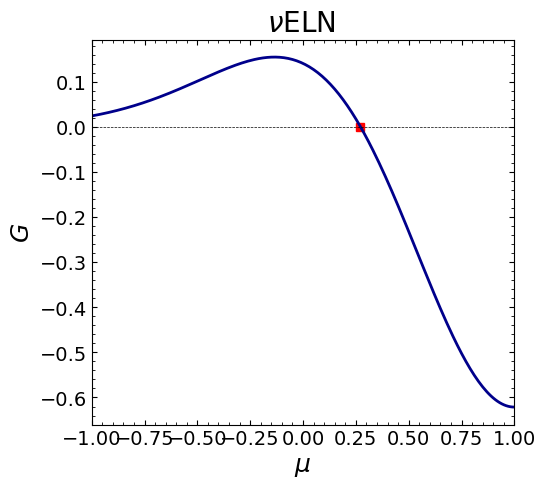

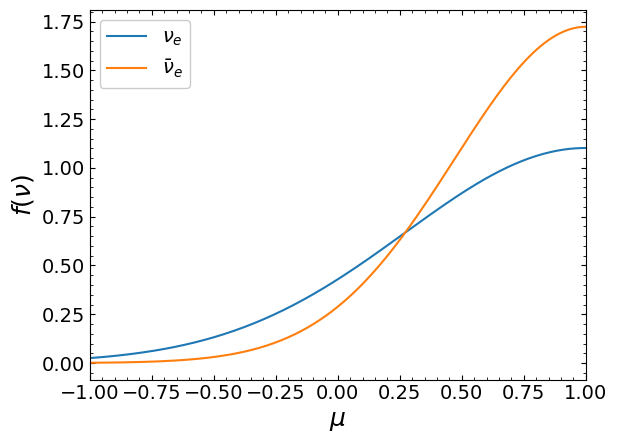

crossing status:  True
crossing point:  0.27000000000000113
Done


In [5]:
# alpha = n_nueb/n_nue, and F_nue and F_nueb are the flux factors of nu_e and nu_eb
alpha, F_nue, F_nueb = 2*random.random(), random.random(), random.random() 
dis1, dis2 = GaussianDist(), GaussianDist()

dis1.params_setter(1., F_nue)         # 1 is the normalized number density of nu_e 
dis2.params_setter(alpha, F_nueb)
cr, mu_c = AngDist.check_crossing(dis1, dis2)
x = np.arange(-1.,1.01,.01)   
G = dis1.angular_distribution(x) - dis2.angular_distribution(x) 
    
# Ploting
fig = plt.figure(figsize=(12,5))
fig.add_subplot(121)
if mu_c: plt.plot(mu_c,0,'rs')   
plt.plot(x,G, 'darkblue', lw=2)
plt.plot(x, np.zeros(x.size),'k--', lw=.5)
plt.title(r'$\nu$ELN ', size=20)
plt.xlabel(r'$\mu$',size=18)
plt.ylabel(r'$G$',size=18)
plt.minorticks_on()
plt.tick_params(axis='y',which='both',left=True,right=True,labelleft=True, direction='in')
plt.tick_params(axis='x',which='both',top=True,bottom=True,labelbottom=True, direction='in')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(-1,1)
plt.show()

fig.add_subplot(122)
plt.plot(x,dis1.angular_distribution(x))
plt.plot(x,dis2.angular_distribution(x))
plt.xlabel(r'$\mu$',size=18)
plt.ylabel(r'$f(\nu)$',size=18)
plt.minorticks_on()
plt.tick_params(axis='y',which='both',left=True,right=True,labelleft=True, direction='in')
plt.tick_params(axis='x',which='both',top=True,bottom=True,labelbottom=True, direction='in')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend((r'$\nu_e$',r'$\bar\nu_e$'), loc = 'upper left', fontsize=14, fancybox=True, framealpha=1.)
plt.xlim(-1,1)

plt.show()
print('crossing status: ', cr)
print('crossing point: ',  mu_c)
print("Done")

## Producing the datasets
In the following cell, we produce two datasets using the Gaussian and maximum entropy angular distributions defined above.

<br>

In [6]:
def make_data(distribution_class, alpha_array, num_pnts):
    """ 
    This function generates a dataset containing a number of nu_e and nu_eb angular distributions, and 
    whether there exists a crossing for them.
        
    Parameters
    ----------
    distribution_class: python class
        the type of the neutrino angular distribution, currently MaxentDist & GaussianDist
    alpha_array : numpy 1D array
        includes the values of alpha = n_nueb/n_nue for which the ELN angular distribution is investigated
    num_pnts: int
        the number of random points in the (F_nue, F_nueb) parameter space for each alpha
        
    Returns
    -------
    numpy array 
        of the size (alpha_array.size, num_pnts, 8) where 8 refers to [alpha, F_nue, F_nueb, ELN_crossing, 
        prm_nue1, prm_nue2, prm_nueb1, prm_nueb2] with prm_nue and prm_nueb being the parameters of nu_e and 
        nu_eb distributions
    """
    
    data = np.zeros((alpha_array.size, num_pnts, 8))
    for alp in range(alpha_array.size):
        n = 0
        while n < num_pnts:
            alpha, F_nue, F_nueb = alpha_array[alp], random.random(), random.random() 
            dist1, dist2 = (distribution_class() for _ in range(2))
            dist1.params_setter(1., F_nue)    # The number density of nu_e = 1 (everything is normalized by n_nue)
            dist2.params_setter(alpha, F_nueb)
            # We only count the points if the solver has done its job correctly
            if dist1.check_solver() and dist2.check_solver():
                data[alp, n, :3] = alpha, F_nue, F_nueb
                if AngDist.check_crossing(dist1, dist2)[0]: data[alp, n, 3] = 1    # If ELN crossing is absent, it is 0
                data[alp, n, 4:] = *dist1.args, *dist2.args    # The parameters, e.g, a & eta
                n += 1
    return data 


# The array of alpha, and the number of random points in the (F_nue, F_nueb) parameter space 
# for which we find the angular distributions for each alpha.
ALPHA = np.arange(0.001,2.5,.03)
NUM_PNTS = 700


# Producing two angular distributions with the dimensions (ALPHA.size, NUM_PNTS, 8)
# This might take ~2-3 minutes
data_max_ent = make_data(MaxentDist, ALPHA, NUM_PNTS) 
data_gaussian= make_data(GaussianDist, ALPHA, NUM_PNTS)



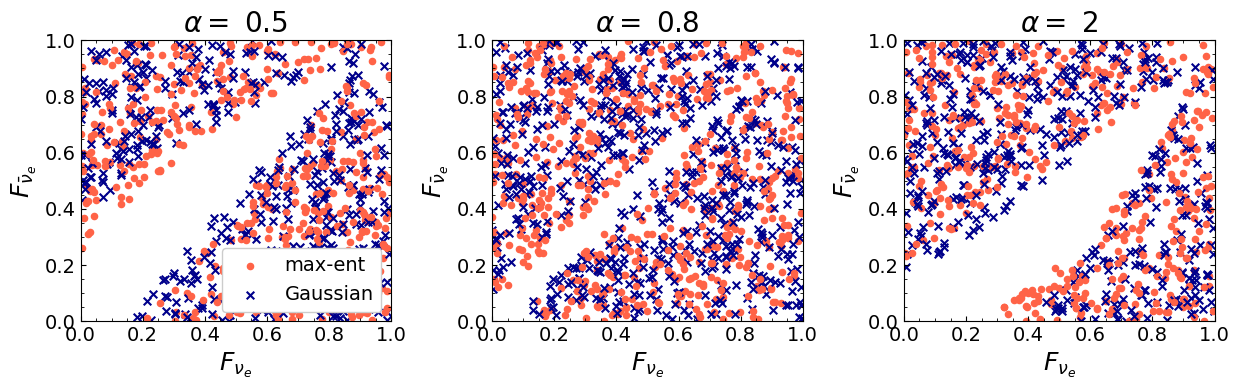

In [7]:
def make_subplots(alpha, legend=False):
    """ 
    This function makes a scatter plot of the zones for which ELN crossing exist, in (F_nue, F_nueb), given alpha.
        
    """
    
    plt.title(r'$\alpha = $ ' + str(alpha), size=20)
    plt.xlabel(r'$F_{\nu_e}$',size=18)
    plt.ylabel(r'$F_{\bar\nu_e}$',size=18)
    plt.scatter(2, 2, marker='o',color='tomato',s=20, alpha=1); 
    plt.scatter(2, 2, marker='x',color='darkblue',s=30, alpha=1)
    alpha_ind = np.argmin(abs(data_gaussian[:,0,0]-alpha))
    for i in range(0, NUM_PNTS):
        if data_max_ent[alpha_ind,i,3]>0:
            plt.scatter(data_max_ent[alpha_ind,i,1], data_max_ent[alpha_ind,i,2], marker='o', rasterized=True, label='',color='tomato',s=20, alpha=1)
        if data_gaussian[alpha_ind,i,3]>0:
            plt.scatter(data_gaussian[alpha_ind,i,1], data_gaussian[alpha_ind,i,2], marker='x', rasterized=True, label='',color='darkblue',s=30, alpha=1)
    plt.minorticks_on()
    plt.tick_params(axis='y',which='both',left=True,right=True,labelleft=True, direction='in')
    plt.tick_params(axis='x',which='both',top=True,bottom=True,labelbottom=True, direction='in')
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.ylim(-0.0001,1.)
    plt.xlim(-0.0001,1.)
    if legend: plt.legend(("max-ent","Gaussian"), loc = 'lower right', fontsize=14, fancybox=True, framealpha=1.)



fig = plt.figure(figsize=(12.5,4))

fig.add_subplot(131); make_subplots(0.5, legend=True)
fig.add_subplot(132); make_subplots(0.8)
fig.add_subplot(133); make_subplots(2)












plt.tight_layout() 
plt.show()

# fig.savefig("Fig_prmspace.pdf")

## Data splitting

In order to train/test the ML algorithms, we split our dataset into training and test sets. Though we do not show it here, we consider anotehr independent set as our development set, to fix the hyper-parameters of the ML algorithms.

<br><br>

In [8]:
from sklearn.model_selection import train_test_split

data = np.concatenate((data_gaussian, data_max_ent), axis=1)     # combine the two data sets

X = data[:,:,:3].reshape(data[:,0,0].size*data[0,:,0].size, 3)
y = data[:,:,3].reshape(data[:,0,0].size*data[0,:,0].size)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=10)

# ML algorithms

In this part, we show our results on detecting νELN crossings with the application of ML algorithms. We first focus on Logistic Regression (LR), which turns out to be the most promising ML algorithm to be used in detecting νELN crossings. 

In order to capture the non-linear patterns,  one should first make non-linear transformations and generate new features out of the original three
features in  the problem. *Python sklearn* provides a module which does this, given the polynomial degree of the
nonlinear transformation, which is a hyper-parameter of this algorithm. We have fixed this parameter to be 9 (see Fig.~2 of the paper). 


Note that this might take a few minutes since the LR algorithm converges slowly.

<br><br>

In [9]:
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures, scale


lin_mod = LogisticRegression(max_iter=100000, class_weight={0: 2, 1: 1}, )

# We first make a polynomial transfomration to use the LR for a nonlinear problem
poly = PolynomialFeatures(degree = 9, interaction_only=False, include_bias=False)
XX_train = poly.fit_transform(X_train); XX_test = poly.fit_transform(X_test)
# XX_train = scale(XX_train); XX_test = scale(XX_test)

lin_mod.fit(XX_train,y_train)
prediction = lin_mod.predict(XX_test)
target_names = ['no crossing', 'crossing']
score = sklearn.metrics.classification_report(y_test, prediction, target_names=target_names)
print(score)

              precision    recall  f1-score   support

 no crossing       0.83      0.92      0.88      6237
    crossing       0.97      0.93      0.95     17283

    accuracy                           0.93     23520
   macro avg       0.90      0.93      0.91     23520
weighted avg       0.93      0.93      0.93     23520



## LR classification error

Let's make a plot to see where the LR algorithm fails to predict the right classification for $\alpha$'s in the range (0.7,1.3), which is more relevant regarding CCSNe and NSM's. This provides us with an understanding of where the accuracy is minimum. As one can see, the following plots makes completely sense since this is the region where one has noisy dataset (see the discussion in the paper).

<br><br>

In [10]:
fig = plt.figure(figsize=(4,4))
plt.title('Misclassifications', size=20)
plt.xlabel(r'$F_{\nu_e}$',size=18)
plt.ylabel(r'$F_{\bar\nu_e}$',size=18)
plt.minorticks_on()
plt.tick_params(axis='y',which='both',left=True,right=True,labelleft=True, direction='in')
plt.tick_params(axis='x',which='both',top=True,bottom=True,labelbottom=True, direction='in')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(-0.0001,1.)
plt.xlim(-0.0001,1.)

for i in range(prediction.size):
    if (prediction[i]-y_test[i])>1.e-3 and XX_test[i,0]>0.7 and XX_test[i,0]<1.3:
        plt.scatter(XX_test[i,1], XX_test[i,2], marker='o',color='red',s=20, alpha=1); 


In [11]:
# Saving the coef. of the Logistic Regression classifier and poly.fit_transform
np.save("poly_powers_2",  poly.powers_)
np.save("lin_mod_intercept_2", lin_mod.intercept_)
np.save("lin_mod_coef_2", lin_mod.coef_)

## Using the trained LR classifier 

We here show how one can download the coefficients (as saved in the previous cell, which is commented now) regarding the Logistic Regression classifier (LRC) to detect $\nu$ELN crossings in NSM and CCSN simulations. Note that in order to use LRC, we need to first make a non-linear transformation and then find the linear weights, $w$. In the following, we have considered a nonlinear polynomial transformation with degree=9. The code needs some x0 with three components with [$\alpha$, $F_{\nu_e}$, $F_{\bar\nu_e}$].

**IMPORTANT**

Please make sure $\alpha$ is always in the range (0.05, 2.4). If not, for using LRC just add an if statement and set it equal to 0.05 or 2.4.

In [12]:
# We here build the Logistic Regression classifier using LogisticRegression coef_
poly_powers_ = np.load("poly_powers_2.npy")
lin_mod_intercept_ = np.load("lin_mod_intercept_2.npy")
lin_mod_coef_ = np.load("lin_mod_coef_2.npy")

x0 = np.array([ .9, .5, .6])           # an example with [alpha, F_nue, F_nueb] 


# One can produce the poly.fit_transform ourselves using poly.powers_
print("shape of poly_powers_: ", poly_powers_.shape)
x0_transformed = np.zeros((poly_powers_[:,0].size))
for i in range(poly_powers_[:,0].size):
    x0_transformed[i] = x0[0]**poly_powers_[i,0] * x0[1]**poly_powers_[i,1] * x0[2]**poly_powers_[i,2]
        
# One can then use the LogisticRegression coef_ and intercept_
print("shape of LR coef_: ", lin_mod_coef_.shape)
z = lin_mod_intercept_ + np.dot(x0_transformed, np.squeeze(lin_mod_coef_))
print("probability of an ELN crossing using coef. = ", 1./(1. + np.exp(-z)))


# And from calling the modul we have ... 
print("probability of an ELN crossing using lin_mod.predict_proba function = ",
      lin_mod.predict_proba(poly.fit_transform(x0.reshape(1,3)))[0,1])


shape of poly_powers_:  (219, 3)
shape of LR coef_:  (1, 219)
probability of an ELN crossing using coef. =  [0.68185403]
probability of an ELN crossing using lin_mod.predict_proba function =  0.6818540291560433


## KNN

Though KNN is perhaps the simplest and most straightforward algorithm in many different respects, its implementation in detecting $\nu$ELN crossings in CCSN and NSM simulations may not be that efficient. This is because at any classification, one needs to load and analyze the whole training dataset, which could be computationally expensive.

We here also show how the results change once one uses cross validation. Obviously, cross validation does not affect the results since the dataset is already generic enough.

<br><br>

In [1]:
import sklearn
from sklearn import metrics, neighbors

knn = neighbors.KNeighborsClassifier(n_neighbors=3, weights='distance')
knn.fit(X_train,y_train)

prediction = knn.predict(X_test)

target_names = ['no crossing', 'crossing']
print(sklearn.metrics.classification_report(y_test, prediction, target_names=target_names))



# Here we comment on the idea of cross validation. 
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
scores = cross_val_score(knn, X, y, cv=5)
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
print("cross validation scores, with n_splits=5:")
print(cross_val_score(knn, X, y, cv=cv))



NameError: name 'X_train' is not defined

## The performance of SVM \& Decision Tree Classifier

<br><br>

In [14]:
from sklearn import svm

SVM = svm.SVC(kernel='rbf', gamma=100.01)
SVM.fit(X_train,y_train)

prediction = SVM.predict(X_test)

target_names = ['no crossing', 'crossing']
print(sklearn.metrics.classification_report(y_test, prediction, target_names=target_names))

              precision    recall  f1-score   support

 no crossing       0.92      0.89      0.90      6237
    crossing       0.96      0.97      0.97     17283

    accuracy                           0.95     23520
   macro avg       0.94      0.93      0.94     23520
weighted avg       0.95      0.95      0.95     23520



In [15]:
from sklearn.tree import DecisionTreeClassifier

mod = DecisionTreeClassifier(class_weight={0: 2, 1: 1})
mod.fit(X_train,y_train)

prediction = mod.predict(X_test)

target_names = ['class 0', 'class 1']
print(sklearn.metrics.classification_report(y_test, prediction, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.89      0.88      0.89      6237
     class 1       0.96      0.96      0.96     17283

    accuracy                           0.94     23520
   macro avg       0.92      0.92      0.92     23520
weighted avg       0.94      0.94      0.94     23520

